# Premise
Suppose we create an empirical CDF on all observed resonances. If we perform a Mehta Delta-3 statistic on the empirical CDF, we can estimate the number of false and missing resonances. This would be independent of spin-group assignment. However, we need to know the expected results with certain false and missing fractions and level-spacings for each spingroup involved.

In [813]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# Functions

In [743]:
def plot_ecdf(X, E0=0.0, color='k', Density:bool=False, label:str=None):
    N = len(X)
    if label is None:
        plt.hlines(0.0, E0, X[0], color)
    else:
        plt.hlines(0.0, E0, X[0], color, label=label)
    if Density:
        [plt.hlines(idx/N, X[idx-1], X[idx], color) for idx in range(1,N)]
        [plt.vlines(x, idx/N, (idx+1)/N, color) for idx, x in enumerate(X)]
    else:
        [plt.hlines(idx, X[idx-1], X[idx], color) for idx in range(1,N)]
        [plt.vlines(x, idx, (idx+1), color) for idx, x in enumerate(X)]

def WigSemicircleCDF(x):
    """
    CDF of Wigner's semicircle law distribution
    """
    return (x/math.pi) * np.sqrt(1.0 - x**2) + np.arcsin(x)/math.pi + 0.5

def SampleEnergies(EB, Freq, w=None, ensemble='NNE', seed=None, verbose:bool=False):
    """
    ...
    """

    if seed is None:
        seed = np.random.randint(10000)
        if verbose: print(f'Seed: {seed}')
    rng = np.random.default_rng(seed)

    MULTIPLIER = 5
    
    if w == None:       w = 1.0
    if (ensemble in ('GOE','GUE','GSE')) and (w != 1.0):
        raise NotImplementedError(f'Cannot sample "{ensemble}" with Brody parameters')

    if ensemble == 'NNE': # Nearest Neighbor Ensemble
        # Sig = 6.0
        # wig_std = 0.522723200877 # Normalized Wigner distribution standard deviation
        if w == 1.0:
            L_Guess =  Freq * (EB[1] - EB[0]) * MULTIPLIER
            #L_Guess *= 1.5
            #L_Guess += Sig * wig_std * math.sqrt(L_Guess)
            L_Guess = round(L_Guess)

            LS = np.zeros(L_Guess+1, dtype='f8')
            LS[0]  = EB[0] + abs(rng.normal()) * np.sqrt(2/(math.pi * Freq ** 2))
            LS[1:] = np.sqrt((-4/math.pi) * np.log(rng.uniform(size=L_Guess))) / Freq
            E = np.cumsum(LS)
            E = np.array([e for e in E if e <= EB[1]])
        else:
            raise NotImplementedError('No functionality for Brody Distribution yet.')

    elif ensemble == 'GOE': # Gaussian Orthogonal Ensemble
        # Since the eigenvalues do not follow the semicircle distribution
        # exactly, there is a small chance for some values that would never
        # occur with semicircle distribution. Therefore, we make extra
        # eigenvalues and use the ones that are needed. As extra precaution,
        # we select eigenvalues within a margin of the edges of the semicircle
        # distribution.
        margin = 0.1
        N_res_est = Freq*(EB[1]-EB[0])
        N_Tot = round((1 + 2*margin) * N_res_est)

        H = rng.normal(size=(N_Tot,N_Tot)) / math.sqrt(2)
        H += H.T
        H += math.sqrt(2) * np.diag(rng.normal(size=(N_Tot,)) - np.diag(H))
        eigs = np.linalg.eigvals(H) / (2*np.sqrt(N_Tot))
        eigs.sort()
        eigs = eigs[eigs >= -1.0+margin]
        eigs = eigs[eigs <=  1.0-margin]

        E = EB[0] + N_Tot * (WigSemicircleCDF(eigs) - WigSemicircleCDF(-1.0+margin)) / Freq
        E = E[E < EB[1]]

    elif ensemble == 'Poisson':
        NumSamples = rng.poisson(Freq * (EB[1]-EB[0]))
        E = rng.uniform(low=EB[0], high=EB[1], size=(NumSamples,))

    E.sort()
    return E

# Sampling a combined observed distribution

In [744]:
def sample(EB:tuple, Freq, pM:float, pF:float):
    EGs = [SampleEnergies(EB, freq, ensemble='GOE') for freq in Freq]
    E = np.sort([e for Eg in EGs for e in Eg])
    E = E[np.random.rand(E.size) >= pM] # Remove Missing Resonances
    FreqF = pF/(1-pF) * np.sum(Freq)
    EF = SampleEnergies(EB, FreqF, ensemble='Poisson')
    E = np.concatenate((E, EF))
    E = np.sort(E)
    return E

In [745]:
E_max = 100
EB = (0,E_max)

Freq = np.array([1.0, 1.0]) # Level Densities for each spingroup
pM = 0.00 # Percent Missing Resonances
pF = 0.4 # Percent False Resonances

E = sample(EB, Freq, pM, pF)

KeyboardInterrupt: 

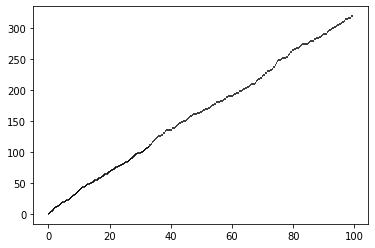

In [746]:
plot_ecdf(E)

# Dyson-Mehta $\Delta_3$

In [754]:
def DeltaMehta3AB(X, XB:tuple, A:float, B:float):
    N  = len(X)
    H  = np.arange(N+1)
    Y  = A*X+B
    PB = (A*XB[0]+B, A*XB[1]+B-N)
    P1 = Y-H[:-1]
    P2 = Y-H[1:]
    return (np.sum(P1**3 - P2**3) + (PB[1]**3 - PB[0]**3))/(3*A*(XB[1]-XB[0]))
    # return (np.sum(P1**2 + P1*P2 + P2**2) + (A*(XB[1]-XB[0])-N)*(PB[1]**2+PB[1]*PB[0]+PB[0]**2))/(3*A*(XB[1]-XB[0]))
def DeltaMehta3(X, XB:tuple):
    N = len(X)
    A0 = N/(XB[1]-XB[0])
    def func(indvars):  return DeltaMehta3AB(X, XB, *indvars)
    sol  = minimize(func, x0=(A0,0))
    a,b = sol.x
    D3 = DeltaMehta3AB(X, XB, a, b)
    return D3, a, b
def PredictedDM3(n):
    return np.maximum(
        math.pi**(-2) * (np.log(n) - 0.0687)
        + 2.2e-2*np.exp(-0.14*n)
        + 1e-1*np.exp(-1*n)
        + 1e-1*np.exp(-4*n), 0.0)

def MehtaD3_2(E, EB):
    z = (E-EB[0])/(EB[1]-EB[0])
    s1 = np.sum(z)
    s2 = np.sum(z**2)
    N = len(z)
    a = np.arange( N-1, -1, -1 )
    s3 = np.sum((2*a+1)*z)
    return 6*s1*s2 - 4*s1**2 - 3*s2**2 + s3

In [ ]:
D3, A, B = DeltaMehta3(E, EB)
print(f'Delta-3 = {D3}')

D3_pred = 2 * PredictedDM3(len(E)/2)
print(f'Predicted Delta-3 = {D3_pred}')

Delta-3 = 7.417693931304508
Predicted Delta-3 = 1.0189087193367812


### Varying number of resonances

In [794]:
num_trials = 1000
NR = np.linspace(0.1, 20, 50)

D3_means = []
D3_stds = []
D3_stdms = []
for num_res_exp in NR:
    EB = (0, float(num_res_exp))
    d3s = []
    for trial in range(num_trials):
        E = sample(EB, Freq=[1.0], pM=0.0, pF=0.0)
        d3 = MehtaD3_2(E, EB)
        d3s.append(d3)
    d3s = np.array(d3s)

    D3_mean = np.mean(d3s)
    D3_std  = np.std(d3s)
    D3_stdm = D3_std / np.sqrt(num_trials)
    D3_means.append(D3_mean)
    D3_stds.append(D3_std)
    D3_stdms.append(D3_stdm)
D3_means = np.array(D3_means)
D3_stds  = np.array(D3_stds)
D3_stdms  = np.array(D3_stdms)

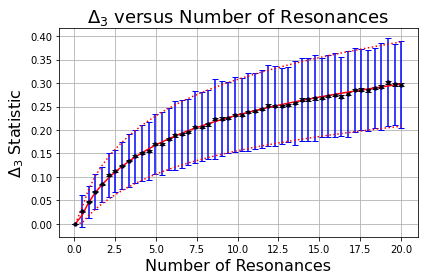

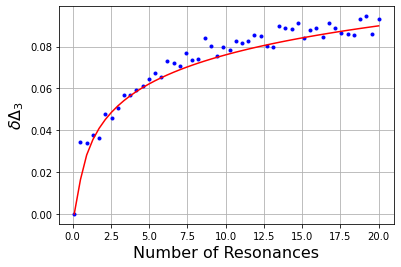

In [804]:
D3_pred = np.maximum(math.pi**(-2) * (np.log(NR) - 0.0687) + 2.2e-2*np.exp(-0.14*NR) + 1e-1*np.exp(-1*NR) + 1e-1*np.exp(-4*NR), 0.0)
D3_std  = np.maximum(0.02 * np.log(NR) + 0.03, 0.0)

plt.figure(42)
plt.clf()
plt.errorbar(NR, D3_means, D3_stds, fmt='.b', capsize=3)
plt.errorbar(NR, D3_means, D3_stdms, fmt='.k', capsize=3)
plt.plot(NR, D3_pred, '-r')
plt.plot(NR, D3_pred-D3_std, ':r')
plt.plot(NR, D3_pred+D3_std, ':r')
plt.title(f'$\Delta_3$ versus Number of Resonances', fontsize=18)
plt.xlabel('Number of Resonances', fontsize=16)
plt.ylabel('$\Delta_3$ Statistic', fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(100)
plt.clf()
plt.plot(NR, D3_stds, '.b')
plt.plot(NR, D3_std, '-r')
plt.xlabel('Number of Resonances', fontsize=16)
plt.ylabel('$\delta\Delta_3$', fontsize=16)
plt.grid()
plt.show()

### Varying Resonance Widths

In [784]:
num_fracs = 11
num_trials = 2000
FreqTot = 1.0 # Sum of Frequencies
pM = 0.00 # Percent Missing Resonances
pF = 0.00 # Percent False Resonances
num_res_exp = 100

EB = (0, num_res_exp / FreqTot)
Fracs = np.linspace(0, 0.1, num_fracs)

D3_means = []
D3_stds = []
D3_stdms = []
for frac in Fracs:
    Freq = np.array([frac*FreqTot, (1-frac)*FreqTot]) # Level Densities for each spingroup
    d3s = []
    for trial in range(num_trials):
        E = sample(EB, Freq, pM, pF)
        d3 = MehtaD3_2(E, EB)
        d3s.append(d3)
    d3s = np.array(d3s)

    D3_mean = np.mean(d3s)
    D3_std  = np.std(d3s)
    D3_stdm = D3_std / np.sqrt(num_trials)
    D3_means.append(D3_mean)
    D3_stds.append(D3_std)
    D3_stdms.append(D3_stdm)
D3_means = np.array(D3_means)
D3_stds  = np.array(D3_stds)
D3_stdms  = np.array(D3_stdms)

print(Fracs)
print(D3_means)
print(D3_stds)
print(D3_stdms)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
[0.46378379 0.51330325 0.55187803 0.58129437 0.60011946 0.62005378
 0.64278289 0.64882523 0.66303889 0.6702038  0.68065289]
[0.10619363 0.13068511 0.14987395 0.16086175 0.16691593 0.16888767
 0.1789922  0.18127953 0.18140606 0.18457488 0.18566675]
[0.00237456 0.00292221 0.00335128 0.00359698 0.00373235 0.00377644
 0.00400239 0.00405353 0.00405636 0.00412722 0.00415163]


<ipython-input-754-fef52a18d6b6>:20: RuntimeWarning: divide by zero encountered in log
  math.pi**(-2) * (np.log(n) - 0.0687)
<ipython-input-786-0c30cd41ee0e>:3: RuntimeWarning: divide by zero encountered in log
  D3_std = np.maximum(0.02 * np.log(Fracs*num_res_exp) + 0.03, 0.0) + np.maximum(0.02 * np.log((1-Fracs)*num_res_exp) + 0.03, 0.0)


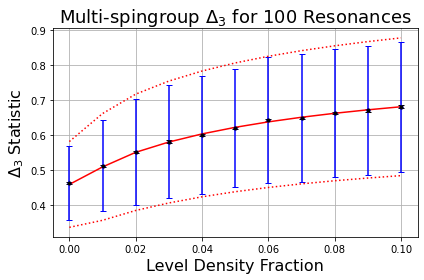

In [786]:
# D3_pred = math.pi**(-2) * (np.log(Fracs*num_res_exp) + np.log((1-Fracs)*num_res_exp) - 2*0.0687)
D3_pred = PredictedDM3(Fracs*num_res_exp) + PredictedDM3((1-Fracs)*num_res_exp)
D3_std = np.maximum(0.02 * np.log(Fracs*num_res_exp) + 0.03, 0.0) + np.maximum(0.02 * np.log((1-Fracs)*num_res_exp) + 0.03, 0.0)

plt.figure(42)
plt.clf()
plt.errorbar(Fracs, D3_means, D3_stds, fmt='.b', capsize=3)
plt.errorbar(Fracs, D3_means, D3_stdms, fmt='.k', capsize=3)
plt.plot(Fracs, D3_pred, '-r')
plt.plot(Fracs, D3_pred-D3_std, ':r')
plt.plot(Fracs, D3_pred+D3_std, ':r')
plt.title(f'Multi-spingroup $\Delta_3$ for {num_res_exp} Resonances', fontsize=18)
plt.xlabel('Level Density Fraction', fontsize=16)
plt.ylabel('$\Delta_3$ Statistic', fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

### Varying False Fraction

In [791]:
num_fracs = 11
num_trials = 500
FreqTot = 1.0 # Sum of Frequencies
pM = 0.00 # Percent Missing Resonances
num_res_exp = 100

EB = (0, num_res_exp/FreqTot)
pFs = np.linspace(0, 1.0, num_fracs+2)[1:-1]

D3_means = []
D3_stds = []
D3_stdms = []
for pF in pFs:
    Freq = [(1-pF)*FreqTot]
    d3s = []
    for trial in range(num_trials):
        E = sample(EB, Freq, pM, pF)
        d3, a, b = DeltaMehta3(E, EB)
        d3s.append(d3)
    d3s = np.array(d3s)

    D3_mean = np.mean(d3s)
    D3_std  = np.std(d3s)
    D3_stdm = D3_std / np.sqrt(num_trials)
    D3_means.append(D3_mean)
    D3_stds.append(D3_std)
    D3_stdms.append(D3_stdm)
D3_means = np.array(D3_means)
D3_stds  = np.array(D3_stds)
D3_stdms  = np.array(D3_stdms)

print(pFs)
print(D3_means)
print(D3_stds)
print(D3_stdms)

[0.08333333 0.16666667 0.25       0.33333333 0.41666667 0.5
 0.58333333 0.66666667 0.75       0.83333333 0.91666667]
[1.00325943 1.53987212 2.09233361 2.6415877  3.17330789 3.69622917
 4.32595523 4.77997713 5.32854402 6.36487419 6.44980678]
[0.51035813 0.73336393 1.19901496 1.53693746 2.00663919 2.19199516
 2.73808416 2.75421793 3.16854223 4.18088043 3.84022464]
[0.02282391 0.03279703 0.05362158 0.06873393 0.08973963 0.098029
 0.12245085 0.12317237 0.14170152 0.18697466 0.17174007]


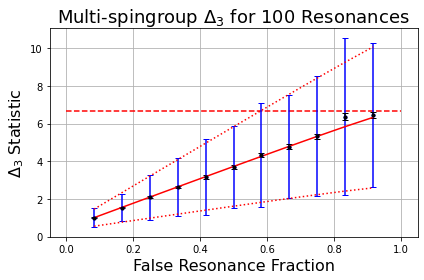

In [793]:
D3_mean = PredictedDM3((1-pFs)*num_res_exp) + (pFs*num_res_exp) / 15
D3_std  = np.maximum(0.02 * np.log((1-pFs)*num_res_exp) + 0.03, 0.0) + (pFs * num_res_exp) / 25

plt.figure(43)
plt.clf()
plt.hlines(num_res_exp/15, 0.0, 1.0, 'r', '--')
plt.errorbar(pFs, D3_means, D3_stds, fmt='.b', capsize=3)
plt.errorbar(pFs, D3_means, D3_stdms, fmt='.k', capsize=3)
plt.plot(pFs, D3_mean, '-r')
plt.plot(pFs, D3_mean-D3_std, ':r')
plt.plot(pFs, D3_mean+D3_std, ':r')
plt.title(f'Multi-spingroup $\Delta_3$ for {num_res_exp} Resonances', fontsize=18)
plt.xlabel('False Resonance Fraction', fontsize=16)
plt.ylabel('$\Delta_3$ Statistic', fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
num_res_exp = 300
num_trials = 1000

d3s = []
for trial in range(num_trials):
    # NumSamples = np.random.poisson(num_res_exp)
    NumSamples = num_res_exp
    E = np.random.uniform(low=0, high=1, size=(NumSamples,))
    E.sort()
    d3, a, b = DeltaMehta3(E, (0,1))
    d3s.append(d3)

D3_mean = np.mean(d3s)
D3_mean_exp = num_res_exp / 15

D3_std  = np.std(d3s)
D3_stdm = D3_std / np.sqrt(num_trials)
D3_std_exp = num_res_exp / 25

print(f'Mean     = {D3_mean:.5f}')
print(f'Expected = {D3_mean_exp :.5f}')
print(f'Standard deviation of mean = {D3_stdm:.5f}')
print()
print(f'Standard deviation = {D3_std:.5f}')
print(f'Expected = {D3_std_exp} (guessed)')

Mean     = 19.97490
Expected = 20.00000
Standard deviation of mean = 0.39311

Standard deviation = 12.43111
Expected = 12.0 (guessed)


# False Resonance Fraction Estimation
Now that we have studied the expected $\Delta_3$ and variance for any combination of multiple true and false resonances, we can now use the statistic to predict the number of false resonances.

In [831]:
def mehtaGOEPredictor(num_res:int):
    """
    ...
    """
    D3_mean = np.maximum(
        math.pi**(-2) * (np.log(num_res) - 0.0687)
        + 2.2e-2*np.exp(-0.14*num_res)
        + 1e-1*np.exp(-1*num_res)
        + 1e-1*np.exp(-4*num_res), 0.0)
    D3_std  = np.maximum(0.02 * np.log(num_res) + 0.03, 0.0)
    return D3_mean, D3_std

def mehtaPoissonPredictor(num_res:int):
    """
    ...
    """
    D3_mean = num_res / 15
    D3_std  = num_res / 25
    return D3_mean, D3_std

def mehtaPredictor(num_res:int, frac_Gs, frac_F:float=0.0, frac_M:float=0.0):
    """
    ...
    """
    if frac_M != 0.0:
        raise NotImplementedError('Non-zero "pM" has not been implemented yet.')
        # Look at https://www.osti.gov/servlets/purl/1478482; Eq. 39
    if frac_Gs.ndim == 1:
        frac_Gs = frac_Gs.reshape(1,-1)
    num_res_Gs = frac_Gs * num_res
    num_res_false = frac_F * num_res
    D3_mean_Gs, D3_std_Gs = mehtaGOEPredictor(num_res_Gs)
    D3_mean_false, D3_std_false = mehtaPoissonPredictor(num_res_false)
    D3_mean = np.sum(D3_mean_Gs, axis=1) + D3_mean_false
    D3_std  = np.sum(D3_std_Gs , axis=1) + D3_std_false
    return D3_mean, D3_std

def false_prediction(D3:float, num_res:int, frac_Gs_T, frac_M:float=0.0):
    frac_Fs = np.linspace(0.0, 1.0, 1000)
    frac_Gs = (1-frac_Fs.reshape(-1,1))*frac_Gs_T.reshape(1,-1)
    D3_means, D3_stds = mehtaPredictor(num_res, frac_Gs, frac_Fs, frac_M)
    probs_F = norm.pdf((D3-D3_means)/D3_stds)/D3_stds
    norm_fact = np.trapz(probs_F, frac_Fs, axis=0)
    mean = np.trapz(frac_Fs * probs_F, frac_Fs, axis=0) / norm_fact
    var  = np.trapz((frac_Fs-mean)**2 * probs_F, frac_Fs, axis=0) / norm_fact
    std = np.sqrt(var)
    return mean, std

In [853]:
D3 = 2.0
num_res = 100
frac_Gs_T = np.array([1.0])

mean, std = false_prediction(D3, num_res, frac_Gs_T)

print(f'{mean:.5f} +/- {std:.5f}')

0.37489 +/- 0.22719


<ipython-input-831-a3cc1c3e032b>:6: RuntimeWarning: divide by zero encountered in log
  math.pi**(-2) * (np.log(num_res) - 0.0687)
<ipython-input-831-a3cc1c3e032b>:10: RuntimeWarning: divide by zero encountered in log
  D3_std  = np.maximum(0.02 * np.log(num_res) + 0.03, 0.0)
